# Anomalies and monthly mean from ERAinterm dataset
This calculated the variance from 6hourly ERAinterim output. 
Wind speed was previously claculated from ERAineterm using a bash script here:
`/local/data/artemis/workspace/gloege/data/ERAinterim/calculate_u10.sh`

Here I calculate variance and mean for each month of 6 hourly output. 
Files are saved here: `/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean/ERA_interim`

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import os

In [2]:
data_dir = '/local/data/artemis/workspace/gloege/data/ERAinterim/ERAinterim_1x1'

## wind speed anomalies

In [ ]:
def ERAinterim_anom(data_dir=None, var_name='u10'):
    '''
    Calculate anomalies
    
    Inputs
    =======
    data_dir: directory where ERAinterm located 
              default: '/local/data/artemis/workspace/gloege/data/ERAinterim/ERAinterim_1x1', 
    var_name: variable name (default: 'u10')
    exp: exponent (default: 2) 
    years: years to consider (default: [1982, 2017])
    
    Output
    ========
    ds_out : dataset with monthly averaged wind speed to power POW
    
    '''
    # Initialize output dataset
    ds_out_anom = xr.Dataset()

    for year in tqdm(np.arange(1982,2017)):
        #print(year)
        # open data file
        fl = f'{data_dir}/ERAinterim_1x1_{year}.nc'
        ds = xr.open_dataset(fl)

        # date vector
        dates = pd.date_range(start=f'{year}-01-01T00:00:00.000000000', 
                              end=f'{year}-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

        # rename coordinates
        ds = ds.rename({'wind_time':'time', 'xlon':'lon', 'ylat':'lat'})

        # calculate monthly mean 
        ds_mean = ds[var_name].groupby('time.month').mean('time')

        # calculate the anomalies for each month
        ds_anom = ds[var_name].groupby('time.month') - ds_mean

        # merge with output
        ds_out = xr.merge([ds_out, ds_anom])
    
    return ds_out_anom

# heading
## heading2
### heading 3

asldfjlasdjflasjdflkjasdf

$\frac{1}{\mu}$

_italics_ and __bolded__ text

## Monthly mean wind speed to power

In [3]:
from tqdm import tqdm

def wind_speed_pow(data_dir='/local/data/artemis/workspace/gloege/data/ERAinterim/ERAinterim_1x1', 
                   var_name='u10', 
                   power=2, 
                   years=[1982, 2017]):
    '''
    wind_speed_pow 
    Calculates the monthly mean of U^(power).
    Where U is the ERAinterm wind speed and pow is some power. 
    This is necessary since gas transfer velocity is commonly 
    parameterized as wind speed to some power. 
    
    Inputs
    =======
    data_dir: directory where ERAinterm located 
              default: '/local/data/artemis/workspace/gloege/data/ERAinterim/ERAinterim_1x1', 
    var_name: variable name (default: 'u10')
    exp: exponent (default: 2) 
    years: years to consider (default: [1982, 2017])
    
    Output
    ========
    ds_out : dataset with monthly averaged wind speed to power POW
    
    '''
    # Initialize output dataset
    ds_out = xr.Dataset()

    for year in tqdm(np.arange(years[0], years[1])):
        #print(year)
        # open data file
        fl = f'{data_dir}/ERAinterim_1x1_{year}.nc'
        ds = xr.open_dataset(fl)

        # date vector
        dates = pd.date_range(start=f'{year}-01-01T00:00:00.000000000', 
                              end=f'{year}-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

        # rename coordinates
        ds = ds.rename({'wind_time':'time', 'xlon':'lon', 'ylat':'lat'})

        # muliply by exponent and take a monthly average
        ds_tmp = (ds[var_name]**power).groupby('time.month').mean('time')
     
        # Put date vector into dataset
        ds_tmp['month'] = dates
        ds_tmp = ds_tmp.rename({'month':'time'})
    
        # merge with output
        ds_out = xr.merge([ds_out, ds_tmp])
    
    # Change attributes 
    ds_out['u10'].attrs = {'long_name':f'monthly mean of wind speed to the power {power}', 
                           'units':f'm^{pow}/s^{power}'}
    
    return ds_out

In [4]:
data_dir = '/local/data/artemis/workspace/gloege/data/ERAinterim/ERAinterim_1x1'
pow=2
ds_out = wind_speed_pow(data_dir=data_dir, exp=2, years=[1982, 1985])

100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


## Calculate Variance (make into a function)

In [ ]:
# Initialize output dataset
ds_out_var = xr.Dataset()
ds_out_mean = xr.Dataset()

for year in tqdm(np.arange(1982, 2017)):
    #print(year)
    # open data file
    fl = f'{data_dir}/ERAinterim_1x1_{year}.nc'
    ds = xr.open_dataset(fl)

    # date vector
    dates = pd.date_range(start=f'{year}-01-01T00:00:00.000000000', 
                          end=f'{year}-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

    # rename coordinates
    ds = ds.rename({'wind_time':'time', 'xlon':'lon', 'ylat':'lat'})

    # calculate variance 
    # this would need to be changed if not using U2 param 
    ds_var = ds['u10'].groupby('time.month').var('time')
    ds_mean = ds['u10'].groupby('time.month').mean('time')
    
    # Put date vector into dataset
    ds_var['month'] = dates
    ds_var = ds_var.rename({'month':'time'})
    
    # Put date vector into dataset
    ds_mean['month'] = dates
    ds_mean = ds_mean.rename({'month':'time'})
    
    # merge with output
    ds_out_var = xr.merge([ds_out_var, ds_var])
    ds_out_mean = xr.merge([ds_out_mean, ds_mean])
    
    
# Rename variables 
ds_out_var = ds_out_var.rename({'u10':'u10_var'})
ds_out_mean = ds_out_mean.rename({'u10':'u10_mean'})

# Group into one dataset
ds_out = xr.merge([ds_out_var, ds_out_mean])

ds_out['u10_var'].attrs = {'long_name':'variance from 6 hourly output over each month', 
                          'units':'m2/s2'}
ds_out['u10_mean'].attrs = {'long_name':'mean from 6 hourly output over each month', 
                          'units':'m/s'}

ds_out.attrs = {'source':'/local/data/artemis/workspace/rdussin/ERAinterim',
               'contact':'R. Dussin downloaded ERAinterm, L. Gloege created this product'}

# Save to netcdf
dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean'
ds_out.to_netcdf(f'{dir_clean}/ERA_interim/ERAinterim_1x1_u10-var_1982-2016.nc')

# Test plots

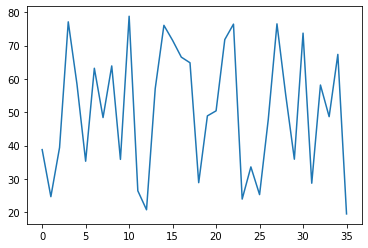

In [74]:
plt.plot(ds_out_mean['u10'][:,0,0]**2)

In [ ]:
plt.plot(ds_out['u10'][:,0,0],'r')
plt.plot(ds_out_mean['u10'][:,0,0]**2)

In [ ]:
plt.plot(ds_anom2[:,0,0])
plt.plot(ds_var[:,0,0])

In [ ]:
# Initialize output dataset
ds_out_anom = xr.Dataset()
ds_out_mean = xr.Dataset()

for year in tqdm(np.arange(1982,1985)):
    #print(year)
    # open data file
    fl = f'{data_dir}/ERAinterim_1x1_{year}.nc'
    ds = xr.open_dataset(fl)

    # date vector
    dates = pd.date_range(start=f'{year}-01-01T00:00:00.000000000', 
                          end=f'{year}-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

    # rename coordinates
    ds = ds.rename({'wind_time':'time', 'xlon':'lon', 'ylat':'lat'})

    # calculate monthly mean 
    ds_mean = ds['u10'].groupby('time.month').mean('time')

    # calculate the anomalies for each month
    ds_anom = ds['u10'].groupby('time.month') - ds_mean

    # Put date vector into dataset
    #ds_mean['month'] = dates
    #ds_mean = ds_mean.rename({'month':'time'})

    # merge with output
    ds_out_anom = xr.merge([ds_out_anom, ds_anom])
    #ds_out_mean = xr.merge([ds_out_mean, ds_mean])
    a